In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold 
from sklearn.preprocessing import StandardScaler, RobustScaler
from keras.layers import Input, InputLayer, Dense, Activation, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Using TensorFlow backend.


In [2]:
data = pd.read_csv('crop_features.csv', index_col=0)

In [3]:
data.rename(columns={"image_time":"label_time"}, inplace = True)

In [4]:
display(data.head())
print(data.shape)

,prob,human_len,ai_len,crop_time,label_time,similarity,correct
0,0.999907,9,9,1469,9676.175212,1.000000,1
1,0.984349,11,10,2086,13740.300539,0.952381,1
2,0.529631,6,6,1248,8220.467436,0.000000,1
3,0.377639,11,9,1692,11145.056813,0.500000,1
4,0.999989,7,7,2854,14746.805014,1.000000,0


(4523, 7)


# EDA

## Features
- `crop_time` - 데이터 생산자가 crop하는 데 걸린 시간
- `label_time` - 데이터 생산자가 labeling하는 데 걸린 시간
- `human_len` - 데이터 생산자가 labeling한 string의 길이
- `ai_len` - AI 어시스턴트가 Recognition한 결과로 반환한 string의 길이
- `prob` - 데이터 생산자가 crop한 영역들을 AI 어시스턴트가 Recognition한 결과로 나온 confident 값
- `similarity` - 데이터 생산자가 labeling한 string과 AI 어시스턴트가 Recognition한 stringdml 유사도

### feature, label 추출
총 데이터 중 feature로 활용할 컬럼과 label로 활용할 컬럼을 추출합니다.

In [5]:
data = data[['crop_time', 'label_time', 'human_len', 'ai_len', 'prob', 'similarity', 'correct']]
display(data.head())

,crop_time,label_time,human_len,ai_len,prob,similarity,correct
0,1469,9676.175212,9,9,0.999907,1.000000,1
1,2086,13740.300539,11,10,0.984349,0.952381,1
2,1248,8220.467436,6,6,0.529631,0.000000,1
3,1692,11145.056813,11,9,0.377639,0.500000,1
4,2854,14746.805014,7,7,0.999989,1.000000,0


### 정상 데이터와 비정상 데이터 수 비교
감지하려고 하는 데이터는 반려, 즉 `failure`된 데이터 이므로 해당 값은 1로, 정상 데이터는 0으로 설정되어 있다.

In [6]:
# done된 데이터와 fail된 데이터 합치기
print("done:", len(data[data['correct'] == 0]))
print("fail:", len(data[data['correct'] == 1]))

done: 3574
fail: 949


### 단위 변경
crop_time, image_time이 단위가 ms이므로 값이 크다. 이를 초 단위로 변경합니다.

In [7]:
data['crop_time'] = data.apply(lambda row: row.crop_time / 1000, axis=1)
data['label_time'] = data.apply(lambda row: row.label_time / 1000, axis=1)
display(data.head())

,crop_time,label_time,human_len,ai_len,prob,similarity,correct
0,1.469,9.676175,9,9,0.999907,1.000000,1
1,2.086,13.740301,11,10,0.984349,0.952381,1
2,1.248,8.220467,6,6,0.529631,0.000000,1
3,1.692,11.145057,11,9,0.377639,0.500000,1
4,2.854,14.746805,7,7,0.999989,1.000000,0


### NULL 값 확인
Null인 값은 없는 것으로 확인

In [8]:
data.isnull().sum()

crop_time     0
label_time    0
human_len     0
ai_len        0
prob          0
similarity    0
correct       0
dtype: int64

### 각 feature별 히스토그램 생성

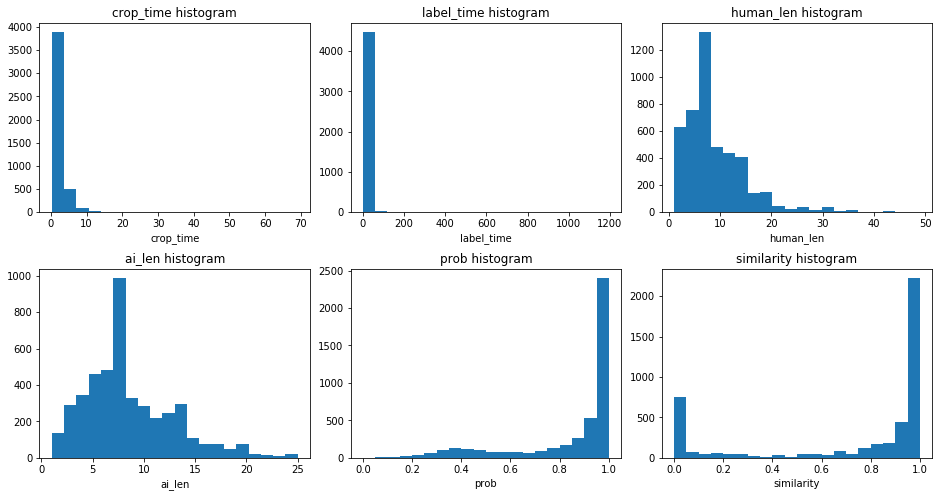

In [9]:
def draw_feature_histogram(dataset, display=''):
    if display == 'linear':
        plt.figure(figsize=(20, 4))
        plt.subplots_adjust(wspace=0.2, hspace=0.25)
    else:
        plt.figure(figsize=(16, 8))
        plt.subplots_adjust(wspace=0.15, hspace=0.3)
    
    for i, column in enumerate(dataset.columns):
        # compare_size 히스토그램
        if display == 'linear':
            plt.subplot(1, len(dataset.columns), i+1)
        else:
            plt.subplot(2, 3, i+1)
        plt.hist(dataset[column], bins=20)
        plt.xlabel(column)
        plt.title(f'{column} histogram')

    plt.show()
    
draw_feature_histogram(data[['crop_time', 'label_time', 'human_len', 'ai_len', 'prob', 'similarity']])

# 데이터 정제
각 feature별로 히스토그램을 그려보니 몇몇 feature에서 이상치가 존재하는 것 같다. 이러한 이상치를 파악하고 제거하고자 한다.

## Box plot
데이터의 이상치가 어떻게 존재하는지 확인하기 위해 각 feature별로 box plot를 그려보도록 한다.

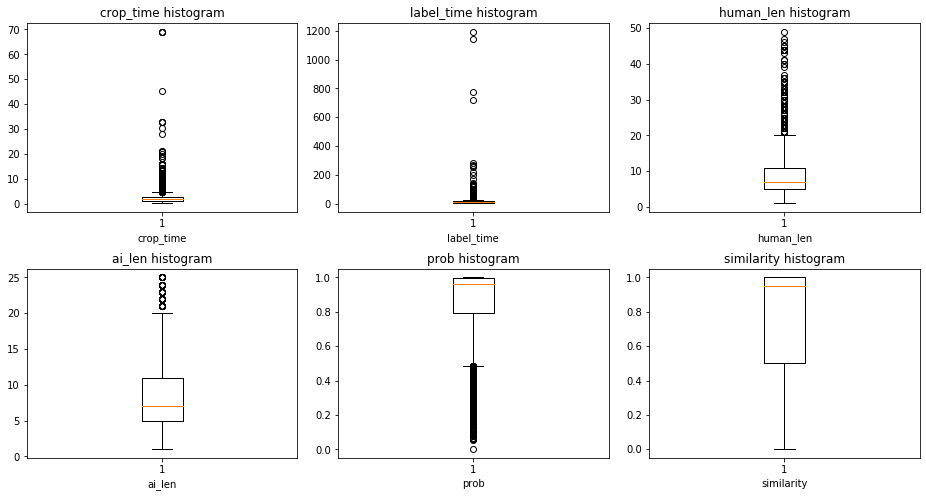

In [10]:
def draw_feature_boxplot(dataset, display=''):
    if display == 'linear':
        plt.figure(figsize=(20, 4))
        plt.subplots_adjust(wspace=0.2, hspace=0.25)
    else:
        plt.figure(figsize=(16, 8))
        plt.subplots_adjust(wspace=0.15, hspace=0.3)
    
    for i, col in enumerate(dataset.columns):
#         dataset[col].plot.box(ax=ax[i])
        if display == 'linear':
            plt.subplot(1, len(dataset.columns), i+1)
        else:
            plt.subplot(2, 3, i+1)
        plt.boxplot(dataset[col])
        plt.xlabel(col)
        plt.title(f'{col} histogram')

draw_feature_boxplot(data[['crop_time', 'label_time', 'human_len', 'ai_len', 'prob', 'similarity']])

## 이상치 제거
`prob` feature은 0~1의 값을 가지므로 이상치라 판단하기 힘들다.

하지만 `crop_time`, `image_time`, `human_len`, `ai_len`의 feature의 경우 범주가 정해진 값이 아니기에 이상치들을 제거한다.
`time` feature의 경우 이상치를 전부 삭제하면 데이터가 크게 손실이 일어나므로 조금은 남겨주도록 한다.

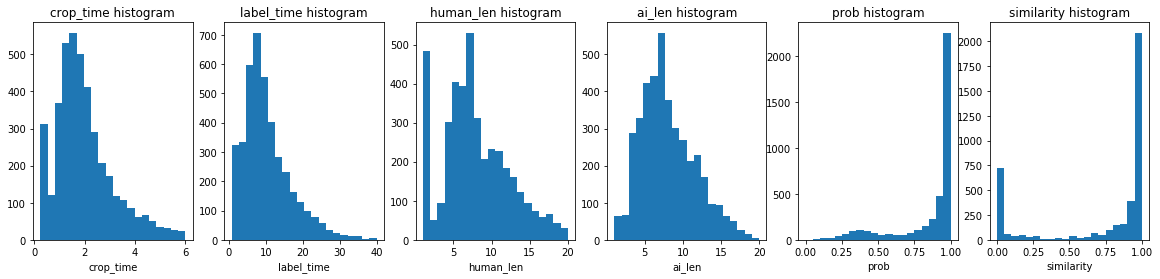

done: 3183
fail: 898


In [11]:
# 라벨 길이가 긴, 시간이 오래걸린 이상치 데이터 제거
data = data[data['crop_time'] <= 6]
data = data[data['label_time'] <= 40]
data = data[data['human_len'] <= 20]
data = data[data['ai_len'] <= 20]

# 제거 후 시각화
# draw_feature_boxplot(data[['crop_time', 'image_time', 'human_len', 'ai_len', 'prob', 'similarity']], 'linear')
draw_feature_histogram(data[['crop_time', 'label_time', 'human_len', 'ai_len', 'prob', 'similarity']], 'linear')

# done된 데이터와 fail된 데이터 수 비교
print("done:", len(data[data['correct'] == 0]))
print("fail:", len(data[data['correct'] == 1]))

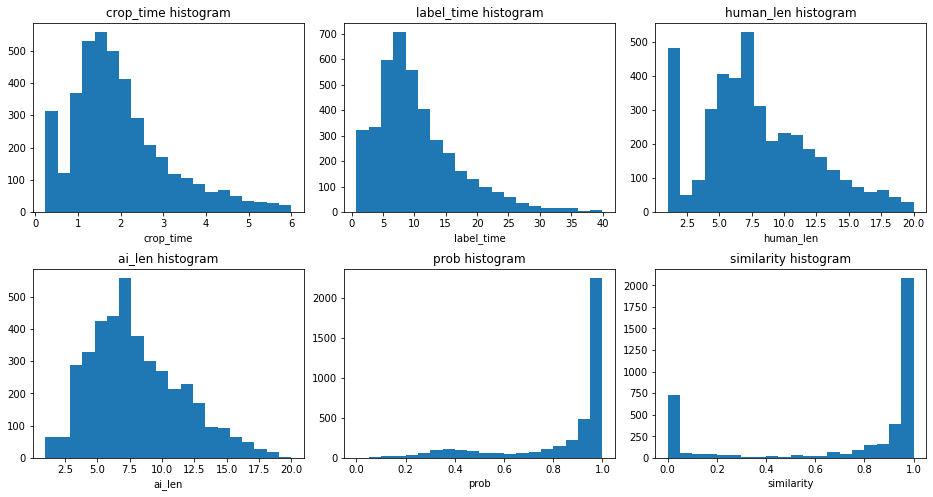

In [12]:
draw_feature_histogram(data[['crop_time', 'label_time', 'human_len', 'ai_len', 'prob', 'similarity']])

## feature 및 labels 추출
데이터 셋에서 feature와 label로 활용할 column을 추출한다.

In [13]:
features = data[['crop_time', 'label_time', 'human_len', 'ai_len', 'prob', 'similarity']]
labels = data[['correct']]

In [14]:
# features.to_csv('features.csv')

# Feature Engineering

## Feature selection
- LinearRegression, LogisticRegression을 통한 feature개수 별 최대 성능을 나타내는 feature들을 찾아본다

### 선형 회귀를 통한 Features Selection

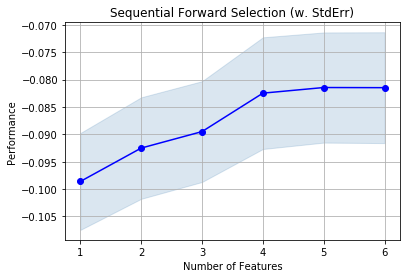

In [15]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
sfs = SFS(lr, 
          k_features=6, 
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=10)
sfs = sfs.fit(features, labels)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [16]:
metric = sfs.get_metric_dict()
for key in metric.keys():
    print("feature_names: {}, avg_score: {}".format(metric[key]['feature_names'], metric[key]['avg_score']))

feature_names: ('similarity',), avg_score: -0.09861742408806137
feature_names: ('prob', 'similarity'), avg_score: -0.09251312510772844
feature_names: ('human_len', 'prob', 'similarity'), avg_score: -0.08949868625055457
feature_names: ('human_len', 'ai_len', 'prob', 'similarity'), avg_score: -0.08247568704296113
feature_names: ('label_time', 'human_len', 'ai_len', 'prob', 'similarity'), avg_score: -0.08144735988741941
feature_names: ('crop_time', 'label_time', 'human_len', 'ai_len', 'prob', 'similarity'), avg_score: -0.08147512063683422


- feature 개수가 5개 일 때, 평균 점수가 -0.820으로 가장 높다.
- 이 때의 features은 `image_time`, `human_len`, `ai_len`, `prob`, `similarity`이다

### 다중선형회귀를 통한 Feature Selection

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model

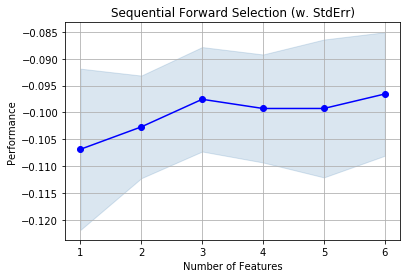

In [17]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
sfs = SFS(lr, 
          k_features=6, 
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=10)
sfs = sfs.fit(features, labels)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [18]:
metric = sfs.get_metric_dict()
for key in metric.keys():
    print("feature_names: {}, avg_score: {}".format(metric[key]['feature_names'], metric[key]['avg_score']))

feature_names: ('human_len',), avg_score: -0.10687094482398667
feature_names: ('human_len', 'ai_len'), avg_score: -0.10269642885959582
feature_names: ('crop_time', 'human_len', 'ai_len'), avg_score: -0.09755235751028933
feature_names: ('crop_time', 'label_time', 'human_len', 'ai_len'), avg_score: -0.09926505336580124
feature_names: ('crop_time', 'label_time', 'human_len', 'ai_len', 'prob'), avg_score: -0.09926204233337846
feature_names: ('crop_time', 'label_time', 'human_len', 'ai_len', 'prob', 'similarity'), avg_score: -0.09656535875074634


- feature 개수가 6개 일 때, 평균 점수가 -0.966으로 가장 높다.
- 이 때의 features은 `image_time`, `crop_time`, `human_len`, `ai_len`, `prob`, `similarity`이다

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model

C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\valida

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model

C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\valida

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model

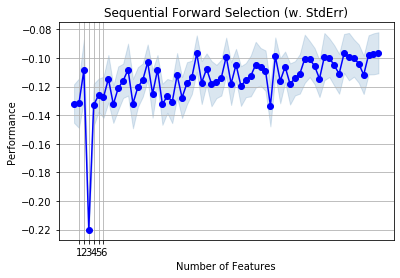

In [19]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
efs = EFS(lr, min_features=1, max_features=6,
          scoring='neg_mean_squared_error')
efs = efs.fit(features, labels)
fig = plot_sfs(efs.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [20]:
metric = efs.get_metric_dict()
for key in metric.keys():
    print("feature_names: {}, avg_score: {}".format(metric[key]['feature_names'], metric[key]['avg_score']))

feature_names: ('crop_time',), avg_score: -0.13185092850545538
feature_names: ('label_time',), avg_score: -0.13160913412079206
feature_names: ('human_len',), avg_score: -0.10859511455196702
feature_names: ('ai_len',), avg_score: -0.22004370320865654
feature_names: ('prob',), avg_score: -0.13283913164277505
feature_names: ('similarity',), avg_score: -0.12597457404389845
feature_names: ('crop_time', 'label_time'), avg_score: -0.12744216083081153
feature_names: ('crop_time', 'human_len'), avg_score: -0.1144672638937907
feature_names: ('crop_time', 'ai_len'), avg_score: -0.1323411253200772
feature_names: ('crop_time', 'prob'), avg_score: -0.12108041540575651
feature_names: ('crop_time', 'similarity'), avg_score: -0.11592704117262768
feature_names: ('label_time', 'human_len'), avg_score: -0.10809830969205007
feature_names: ('label_time', 'ai_len'), avg_score: -0.13185393216240773
feature_names: ('label_time', 'prob'), avg_score: -0.12034121542978578
feature_names: ('label_time', 'similarity

- `ExhaustiveFeatureSelector`를 통해 전체 feature 조합별 점수를 얻었다.
- 전체 feature을 사용했을 때가 -0.0963으로 가장 좋았다.

- 여러 방법으로 feature selection를 진행했을 때, 전체 feature를 선택하여 진행하는 게 더 좋다는 결론을 얻을 수 있었다.

# Embedded methods

## LogisticRegression

C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

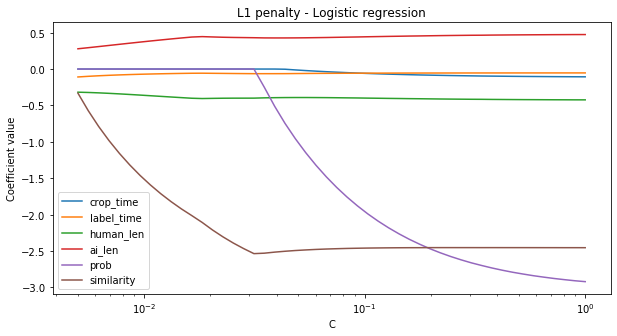

In [21]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.utils import check_random_state
from sklearn.linear_model import LogisticRegression
rnd = check_random_state(1)

cs = np.logspace(-2.3, 0, 50)
coefs = []
for c in cs:
    clf = LogisticRegression(solver='liblinear',C=c,penalty='l1')
    
    clf.fit(features ,labels)
    coefs.append(list(clf.coef_[0]))
    
coefs = np.array(coefs)
plt.figure(figsize=(10,5))
for i,col in enumerate(features.columns):
    plt.plot(cs,coefs[:,i], label=col)
plt.xscale('log')
plt.title('L1 penalty - Logistic regression')
plt.xlabel('C')
plt.ylabel('Coefficient value')
plt.legend()

## LinearSVC

C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

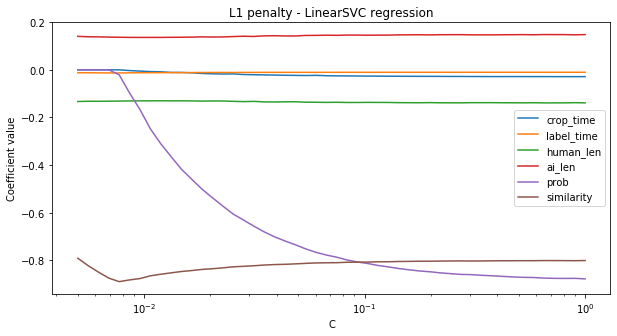

In [22]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.utils import check_random_state
rnd = check_random_state(1)

cs = np.logspace(-2.3, 0, 50)
coefs = []
for c in cs:
    clf = LinearSVC(C=c,penalty='l1', loss='squared_hinge', dual=False, tol=1e-3)
    
    clf.fit(features ,labels)
    coefs.append(list(clf.coef_[0]))
    
coefs = np.array(coefs)
plt.figure(figsize=(10,5))
for i,col in enumerate(features.columns):
    plt.plot(cs,coefs[:,i], label=col)
plt.xscale('log')
plt.title('L1 penalty - LinearSVC regression')
plt.xlabel('C')
plt.ylabel('Coefficient value')
plt.legend()

## main Impurity scores for tree models

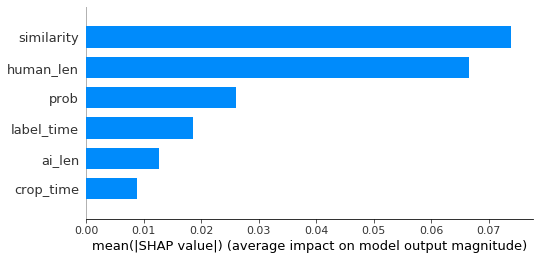

In [23]:
import xgboost
import shap
# load JS visualization code to notebook
shap.initjs()
# train XGBoost model
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(features, label=labels), 100)
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(features)
shap.summary_plot(shap_values, features, plot_type="bar")

In [24]:
from sklearn import svm
x_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4)

clf = svm.SVC(kernel='linear', C=1).fit(x_train, y_train)
clf.score(X_test, y_test)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9081445192896509

In [25]:
from sklearn.model_selection import cross_val_score

clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, features, labels, cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

Accuracy: 0.91 (+/- 0.06)


## Learning curve

In [26]:
# x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.4)

In [27]:
# preds = model.evaluate(x_scaled_test, y_test)

# y_pred = model.predict(x_scaled_test)
# pred_and_label = pd.DataFrame({'index':range(len(y_test)), 'prob':y_pred.T[0], 'correct':y_test.correct})

AttributeError: 'Booster' object has no attribute 'evaluate'

In [ ]:
# visual_model_performance(preds, pred_and_label)

In [33]:
labels.columns=['status']

In [34]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.3)

In [35]:
scaler = RobustScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## Logistic Regression 모델 생성

In [36]:
LR_model = LogisticRegression()
LR_model.fit(x_train_scaled, y_train)
y_pred = LR_model.predict(x_test_scaled)
y_prob = LR_model.predict_proba(x_test_scaled)

print("총 테스트 개수: {}, 오류 개수: {}".format(len(y_pred), (y_pred != y_test.status).sum()))
print("Accuracy(정확도) : {}".format(accuracy_score(y_pred, y_test)))
print("Recall(재현율) : {}".format(recall_score(y_pred, y_test)))
print("Precision(정밀도) : {}".format(precision_score(y_pred, y_test)))
print("F1 score: {}".format(f1_score(y_pred, y_test)))
print('training set R2 결정 계수 : {}'.format(LR_model.score(x_train_scaled, y_train)))
print('test set R2 결정 계수 : {}'.format(LR_model.score(x_test_scaled, y_test)))

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


총 테스트 개수: 1225, 오류 개수: 109
Accuracy(정확도) : 0.9110204081632653
Recall(재현율) : 0.8689320388349514
Precision(정밀도) : 0.685823754789272
F1 score: 0.7665952890792291
training set R2 결정 계수 : 0.8974089635854342
test set R2 결정 계수 : 0.9110204081632653


## KNN 모델 생성

In [37]:
KNN_model = KNeighborsClassifier(n_neighbors=10)
KNN_model.fit(x_train_scaled, y_train)
y_pred = KNN_model.predict(x_test_scaled)
y_prob = KNN_model.predict_proba(x_test_scaled)

print("총 테스트 개수: {}, 오류 개수: {}".format(len(y_pred), (y_pred != y_test.status).sum()))
print("Accuracy(정확도) : {}".format(accuracy_score(y_pred, y_test)))
print("Recall(재현율) : {}".format(recall_score(y_pred, y_test)))
print("Precision(정밀도) : {}".format(precision_score(y_pred, y_test)))
print("F1 score: {}".format(f1_score(y_pred, y_test)))
print('training set R2 결정 계수 : {}'.format(LR_model.score(x_train_scaled, y_train)))
print('test set R2 결정 계수 : {}'.format(LR_model.score(x_test_scaled, y_test)))

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


총 테스트 개수: 1225, 오류 개수: 93
Accuracy(정확도) : 0.9240816326530612
Recall(재현율) : 0.9565217391304348
Precision(정밀도) : 0.6743295019157088
F1 score: 0.7910112359550562
training set R2 결정 계수 : 0.8974089635854342
test set R2 결정 계수 : 0.9110204081632653


## SVM 모델 생성

In [38]:
SVC_model = SVC(probability=True)
SVC_model.fit(x_train_scaled, y_train)
y_pred = SVC_model.predict(x_test_scaled)
y_prob = SVC_model.predict_proba(x_test_scaled)

print("총 테스트 개수: {}, 오류 개수: {}".format(len(y_pred), (y_pred != y_test.status).sum()))
print("Accuracy(정확도) : {}".format(accuracy_score(y_pred, y_test)))
print("Recall(재현율) : {}".format(recall_score(y_pred, y_test)))
print("Precision(정밀도) : {}".format(precision_score(y_pred, y_test)))
print("F1 score: {}".format(f1_score(y_pred, y_test)))
print('training set R2 결정 계수 : {}'.format(LR_model.score(x_train_scaled, y_train)))
print('test set R2 결정 계수 : {}'.format(LR_model.score(x_test_scaled, y_test)))

C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


총 테스트 개수: 1225, 오류 개수: 89
Accuracy(정확도) : 0.9273469387755102
Recall(재현율) : 0.9387755102040817
Precision(정밀도) : 0.7049808429118773
F1 score: 0.8052516411378556
training set R2 결정 계수 : 0.8974089635854342
test set R2 결정 계수 : 0.9110204081632653


## Decision Tree 모델 생성

In [39]:
DT_model = DecisionTreeClassifier()
DT_model.fit(x_train_scaled, y_train)
y_pred = DT_model.predict(x_test_scaled)
y_prob = DT_model.predict_proba(x_test_scaled)

print("총 테스트 개수: {}, 오류 개수: {}".format(len(y_pred), (y_pred != y_test.status).sum()))
print("Accuracy(정확도) : {}".format(accuracy_score(y_pred, y_test)))
print("Recall(재현율) : {}".format(recall_score(y_pred, y_test)))
print("Precision(정밀도) : {}".format(precision_score(y_pred, y_test)))
print("F1 score: {}".format(f1_score(y_pred, y_test)))
print('training set R2 결정 계수 : {}'.format(LR_model.score(x_train_scaled, y_train)))
print('test set R2 결정 계수 : {}'.format(LR_model.score(x_test_scaled, y_test)))

총 테스트 개수: 1225, 오류 개수: 145
Accuracy(정확도) : 0.8816326530612245
Recall(재현율) : 0.7071428571428572
Precision(정밀도) : 0.7586206896551724
F1 score: 0.7319778188539742
training set R2 결정 계수 : 0.8974089635854342
test set R2 결정 계수 : 0.9110204081632653


## 랜덤 포레스트 모델 생성

In [40]:
RF_model = RandomForestClassifier()
RF_model.fit(x_train_scaled, y_train)
y_pred = RF_model.predict(x_test_scaled)
y_prob = RF_model.predict_proba(x_test_scaled)

print("총 테스트 개수: {}, 오류 개수: {}".format(len(y_pred), (y_pred != y_test.status).sum()))
print("Accuracy(정확도) : {}".format(accuracy_score(y_pred, y_test)))
print("Recall(재현율) : {}".format(recall_score(y_pred, y_test)))
print("Precision(정밀도) : {}".format(precision_score(y_pred, y_test)))
print("F1 score: {}".format(f1_score(y_pred, y_test)))
print('training set R2 결정 계수 : {}'.format(LR_model.score(x_train_scaled, y_train)))
print('test set R2 결정 계수 : {}'.format(LR_model.score(x_test_scaled, y_test)))

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


총 테스트 개수: 1225, 오류 개수: 86
Accuracy(정확도) : 0.929795918367347
Recall(재현율) : 0.9396984924623115
Precision(정밀도) : 0.7164750957854407
F1 score: 0.8130434782608695
training set R2 결정 계수 : 0.8974089635854342
test set R2 결정 계수 : 0.9110204081632653


## Simple Neural Net

In [42]:
# 모델 정의
NN_model = Sequential([
    Dense(16, input_shape=(6,)),
    Activation('relu'),
    Dense(64),
    Activation('relu'),
    Dense(12),
    Activation('relu'),
    Dense(1),
    Activation('sigmoid'),
])
# 컴파일
NN_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# Training
NN_model.fit(x_train_scaled, y_train, epochs=120, batch_size=16)
# test
preds = NN_model.evaluate(x=x_test_scaled, y=y_test)
y_prob = NN_model.predict_proba(x_test_scaled)

print(preds)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))


Epoch 1/120
2856/2856 [==============================] - ETA: 24s - loss: 0.7457 - accuracy: 0.375 - ETA: 0s - loss: 0.6635 - accuracy: 0.641 - ETA: 0s - loss: 0.5701 - accuracy: 0.76 - ETA: 0s - loss: 0.4923 - accuracy: 0.81 - ETA: 0s - loss: 0.4534 - accuracy: 0.82 - ETA: 0s - loss: 0.4205 - accuracy: 0.84 - 0s 140us/step - loss: 0.4184 - accuracy: 0.8442
Epoch 2/120
2856/2856 [==============================] - ETA: 0s - loss: 0.5995 - accuracy: 0.68 - ETA: 0s - loss: 0.3049 - accuracy: 0.88 - ETA: 0s - loss: 0.2937 - accuracy: 0.89 - ETA: 0s - loss: 0.2802 - accuracy: 0.90 - ETA: 0s - loss: 0.2752 - accuracy: 0.90 - 0s 84us/step - loss: 0.2692 - accuracy: 0.9055
Epoch 3/120
2856/2856 [==============================] - ETA: 0s - loss: 0.2580 - accuracy: 0.87 - ETA: 0s - loss: 0.2514 - accuracy: 0.90 - ETA: 0s - loss: 0.2522 - accuracy: 0.91 - ETA: 0s - loss: 0.2533 - accuracy: 0.90 - ETA: 0s - loss: 0.2529 - accuracy: 0.90 - 0s 82us/step - loss: 0.2547 - accuracy: 0.9079
Epoch 4/120

2856/2856 [==============================] - ETA: 0s - loss: 0.1791 - accuracy: 0.93 - ETA: 0s - loss: 0.2089 - accuracy: 0.92 - ETA: 0s - loss: 0.2019 - accuracy: 0.93 - ETA: 0s - loss: 0.2052 - accuracy: 0.92 - ETA: 0s - loss: 0.1992 - accuracy: 0.93 - ETA: 0s - loss: 0.2002 - accuracy: 0.92 - 0s 98us/step - loss: 0.2027 - accuracy: 0.9272
Epoch 26/120
2856/2856 [==============================] - ETA: 0s - loss: 0.0896 - accuracy: 1.00 - ETA: 0s - loss: 0.1995 - accuracy: 0.92 - ETA: 0s - loss: 0.2033 - accuracy: 0.93 - ETA: 0s - loss: 0.2082 - accuracy: 0.92 - ETA: 0s - loss: 0.2103 - accuracy: 0.92 - ETA: 0s - loss: 0.2077 - accuracy: 0.92 - 0s 104us/step - loss: 0.2029 - accuracy: 0.9279
Epoch 27/120
2856/2856 [==============================] - ETA: 0s - loss: 0.3145 - accuracy: 0.93 - ETA: 0s - loss: 0.1996 - accuracy: 0.92 - ETA: 0s - loss: 0.2039 - accuracy: 0.92 - ETA: 0s - loss: 0.2121 - accuracy: 0.92 - ETA: 0s - loss: 0.2064 - accuracy: 0.92 - ETA: 0s - loss: 0.2020 - accur

2856/2856 [==============================] - ETA: 0s - loss: 0.1629 - accuracy: 0.93 - ETA: 0s - loss: 0.1814 - accuracy: 0.93 - ETA: 0s - loss: 0.1992 - accuracy: 0.92 - ETA: 0s - loss: 0.1897 - accuracy: 0.92 - ETA: 0s - loss: 0.1932 - accuracy: 0.92 - 0s 84us/step - loss: 0.1879 - accuracy: 0.9286
Epoch 49/120
2856/2856 [==============================] - ETA: 0s - loss: 0.0431 - accuracy: 1.00 - ETA: 0s - loss: 0.1935 - accuracy: 0.93 - ETA: 0s - loss: 0.1783 - accuracy: 0.93 - ETA: 0s - loss: 0.1788 - accuracy: 0.93 - ETA: 0s - loss: 0.1865 - accuracy: 0.93 - 0s 78us/step - loss: 0.1893 - accuracy: 0.9314
Epoch 50/120
2856/2856 [==============================] - ETA: 0s - loss: 0.1958 - accuracy: 0.93 - ETA: 0s - loss: 0.1735 - accuracy: 0.93 - ETA: 0s - loss: 0.1800 - accuracy: 0.93 - ETA: 0s - loss: 0.1834 - accuracy: 0.93 - ETA: 0s - loss: 0.1835 - accuracy: 0.93 - 0s 79us/step - loss: 0.1850 - accuracy: 0.9328
Epoch 51/120
2856/2856 [==============================] - ETA: 0s - 

2856/2856 [==============================] - ETA: 0s - loss: 0.1778 - accuracy: 0.93 - ETA: 0s - loss: 0.2017 - accuracy: 0.92 - ETA: 0s - loss: 0.1821 - accuracy: 0.93 - ETA: 0s - loss: 0.1801 - accuracy: 0.93 - ETA: 0s - loss: 0.1761 - accuracy: 0.93 - 0s 80us/step - loss: 0.1715 - accuracy: 0.9342
Epoch 74/120
2856/2856 [==============================] - ETA: 0s - loss: 0.1749 - accuracy: 0.87 - ETA: 0s - loss: 0.1879 - accuracy: 0.93 - ETA: 0s - loss: 0.1800 - accuracy: 0.93 - ETA: 0s - loss: 0.1796 - accuracy: 0.93 - ETA: 0s - loss: 0.1763 - accuracy: 0.93 - 0s 79us/step - loss: 0.1736 - accuracy: 0.9321
Epoch 75/120
2856/2856 [==============================] - ETA: 0s - loss: 0.2848 - accuracy: 0.87 - ETA: 0s - loss: 0.1821 - accuracy: 0.92 - ETA: 0s - loss: 0.1759 - accuracy: 0.92 - ETA: 0s - loss: 0.1722 - accuracy: 0.93 - ETA: 0s - loss: 0.1713 - accuracy: 0.93 - 0s 83us/step - loss: 0.1744 - accuracy: 0.9328
Epoch 76/120
2856/2856 [==============================] - ETA: 0s - 

2856/2856 [==============================] - ETA: 0s - loss: 0.0675 - accuracy: 0.93 - ETA: 0s - loss: 0.1579 - accuracy: 0.94 - ETA: 0s - loss: 0.1510 - accuracy: 0.94 - ETA: 0s - loss: 0.1475 - accuracy: 0.94 - ETA: 0s - loss: 0.1532 - accuracy: 0.94 - 0s 79us/step - loss: 0.1549 - accuracy: 0.9440
Epoch 99/120
2856/2856 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 1.00 - ETA: 0s - loss: 0.1918 - accuracy: 0.92 - ETA: 0s - loss: 0.1639 - accuracy: 0.93 - ETA: 0s - loss: 0.1616 - accuracy: 0.93 - 0s 70us/step - loss: 0.1582 - accuracy: 0.9377
Epoch 100/120
2856/2856 [==============================] - ETA: 0s - loss: 0.0293 - accuracy: 1.00 - ETA: 0s - loss: 0.1239 - accuracy: 0.95 - ETA: 0s - loss: 0.1431 - accuracy: 0.94 - ETA: 0s - loss: 0.1570 - accuracy: 0.94 - ETA: 0s - loss: 0.1557 - accuracy: 0.94 - 0s 75us/step - loss: 0.1558 - accuracy: 0.9408
Epoch 101/120
2856/2856 [==============================] - ETA: 0s - loss: 0.1338 - accuracy: 0.93 - ETA: 0s 

## 모델별 ROC 커브 및 AUC 확인

In [43]:
from sklearn.metrics import roc_curve, auc

def draw_roc_curve(model, name):
    y_prob = model.predict_proba(x_test_scaled)
    
    false_positive_rate = 0
    true_positive_rate = 0
    thresholds = 0
    if name == 'Neural Net':
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob.T[0])
    else:
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob.T[1])
    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.plot(false_positive_rate, true_positive_rate, label=f'{name} = {roc_auc:.2f}')
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')

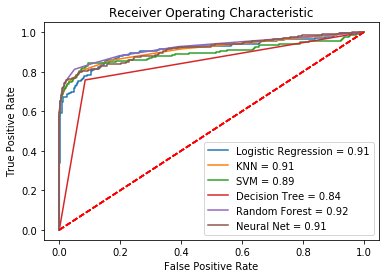

In [44]:
draw_roc_curve(LR_model, 'Logistic Regression')
draw_roc_curve(KNN_model, 'KNN')
draw_roc_curve(SVC_model, 'SVM')
draw_roc_curve(DT_model, 'Decision Tree')
draw_roc_curve(RF_model, 'Random Forest')
draw_roc_curve(NN_model, 'Neural Net')